<p style="text-align:right"><img  src="https://postmba.org/www/wp-content/uploads/2021/10/PostMBA-logo.png" width="150" alt="regression"></p>

<p dir=rtl style="text-align:center;font-family:vazir;font-size:medium;align:left">
    <font face="B nazanin" size=5>
        <b>
pairs trading on Iran Stock Market
<br>
        </b>
</p>

<p dir=rtl style="text-align:center;font-family:vazir;font-size:medium;align:left">
    <font face="B nazanin" size=4>
        <b>
        </b>
</p>

<p style="text-align:center"><img  src="utils/images/pairs_trading.png" width="750" alt="regression"></p>
<p dir=rtl style="text-align:center;font-family:vazir;font-size:medium;align:left">
    <font face="B nazanin" size=3>
        <b>
        </b>
</p>

<p dir=rtl style="text-align:center;font-family:vazir;font-size:medium;align:left">
    <font face="B nazanin" size=2>
        <b>
        </b>
</p>


</font>
</p>


In [1]:
import yfinance as yf
from utils.data_gatherer import *
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import coint
from itertools import combinations
from statsmodels.tsa.stattools import coint
import pickle
import arabic_reshaper
from bidi.algorithm import get_display
from sklearn.preprocessing import MinMaxScaler

<p dir=rtl style="direction: ltr;text-align: left;line-height:200%;font-family:vazir;font-size:medium;align:left">
    <font face="Arial" size=4>
        <b>
            steps of paris trading
        </b>
        
<br>
        1. In the first step, we import the price data of 540 symbols from the Iranian Stock Exchange and Forex into the file tse_symbols_price, and then we perform an initial screening to match all the symbols on the same days.
              
<br>
        2. We perform a stationarity test among all symbol pairs and show that some of them also have stationarity relationships (we can also reject the non-stationarity). Given the large size of this data, we select the pairs whose p-value is below a certain threshold and show that they have stationarity relationships with each other.
<br>
        3. We store the values in a pickle file in the output folder.

<br>
        4. Using the results of the previous step, we identify pairs that have the least p-value and choose them for signal processing and trading.
<br>
        5. We find the Z-score of this ratio for each pair and normalize this Z-score, meaning that Z-scores higher than 1.96 or lower than -1.96 indicate that this ratio has deviated significantly from its historical mean.
<br>
        6. We divide the mean returns of these pairs and extract the statistical coefficient, which shows the mean reverting characteristic of this coefficient over time.

<br>
In this way, we proceed to signal processing and act based on them, which is profitable and another.
<center style="direction: ltr">
The following link is also used for further development of this strategy:

<a href="https://medium.com/call-for-atlas/pairs-trading-strategy-every-stock-needs-a-friend-e50723a1dc94">Pairs-Trading Strategy Analysis</a>
</center>
        
</p>

#### 1. Data Reading

In [2]:
price_data_dict = pd.read_pickle(r'data/tse_symbols_price.pickle')

In [3]:
print(price_data_dict.keys())

dict_keys(['آباد', 'آبادا', 'آپ', 'آسیا', 'اپال', 'اتکام', 'اخابر', 'اردستان', 'اسیاتک', 'افق', 'البرز', 'امید', 'امین', 'انرژی', 'بالبر', 'بترانس', 'برکت', 'بسویچ', 'بشهاب', 'بفجر', 'بکاب', 'بکام', 'بموتو', 'بنیرو', 'بورس', 'بوعلی', 'پارس', 'پارسان', 'پارسیان', 'پاسا', 'پاکشو', 'پتایر', 'پترول', 'پدرخش', 'پرداخت', 'پردیس', 'پسهند', 'پکرمان', 'پکویر', 'پلاسک', 'پی پاد', 'تاپیکو', 'تاصیکو', 'تایرا', 'تپمپی', 'تکنو', 'تملت', 'تنوین', 'تیپیکو', 'ثاخت', 'ثامان', 'ثامید', 'ثبهساز', 'ثشاهد', 'ثشرق', 'ثفارس', 'ثمسکن', 'ثنوسا', 'جم', 'جم پیلن', 'چافست', 'چدن', 'چفیبر', 'چکاپا', 'چکارن', 'چکاوه', 'حتاید', 'حتوکا', 'حفارس', 'حفاری', 'حکشتی', 'خاذین', 'خاهن', 'خبهمن', 'خپویش', 'ختراک', 'ختور', 'ختوقا', 'خچرخش', 'خراسان', 'خریخت', 'خرینگ', 'خزامیا', 'خساپا', 'خشرق', 'خکار', 'خکمک', 'خگستر', 'خلنت', 'خمحرکه', 'خمحور', 'خمهر', 'خموتور', 'خنصیر', 'خودرو', 'دابور', 'داتام', 'دارو', 'داسوه', 'دالبر', 'دامین', 'دانا', 'دپارس', 'دتماد', 'دجابر', 'درازک', 'دروز', 'دزهراوی', 'دسبحا', 'دسبحان', 'دسینا', 'دش

In [4]:
price_data_dict['ولشرق'].head()

,jdate,date,open,high,low,close
0,1398-01-05,2019-03-25,541,552,538,549
1,1398-01-06,2019-03-26,548,568,548,568
2,1398-01-07,2019-03-27,560,583,560,583
3,1398-01-10,2019-03-30,578,580,566,574
4,1398-01-11,2019-03-31,583,583,562,567


#### 2. Data Preproccessing

In [5]:
from datetime import date

START_DATE = date(2020, 1, 1)
END_DATE = date(2023, 12, 20)
START_DATE = date(2020, 1, 1)
Interval_DAYS = (END_DATE - START_DATE).days + 1

In [6]:
#get sanitized data -> handling nan values and same data interval

sanitized_data = {}
for ticker in list(price_data_dict.keys()):
    try:
        prepared_data = price_data_dict[ticker].resample('1D', on='date').last().ffill()[START_DATE: END_DATE]
        if prepared_data.index[0].strftime('%Y-%m-%d')==str(START_DATE) and (len(prepared_data) == Interval_DAYS):
            sanitized_data[ticker] = prepared_data
    except:
        continue

In [7]:
sanitized_data['خودرو'].head()

,jdate,open,high,low,close
date,,,,,
2020-01-01,1398-10-11,466.0,478.0,459.0,461.0
2020-01-02,1398-10-11,466.0,478.0,459.0,461.0
2020-01-03,1398-10-11,466.0,478.0,459.0,461.0
2020-01-04,1398-10-14,442.0,442.0,442.0,442.0
2020-01-05,1398-10-15,439.0,439.0,420.0,424.0


#### 3. Finding Cointegrated Symbols

In [361]:
def find_cointegrated_pairs(tickers_ts_map, p_value_threshold=0.2):
    
    """
    A Function for calculate P-values of Augmented Dickey-Fuller (ADF) test for all 2 symbols in the dataset.
    """

    tickers = list(sanitized_data.keys())
    n = len(tickers)
    adj_close_data = np.column_stack([tickers_ts_map[ticker]['close'].values for ticker in tickers])
    
    # Calculate cointegration p-values
    pvalue_matrix = np.ones((n, n))
    for stock_i, stock_j in combinations(range(n), 2):
        result = coint(adj_close_data[:, stock_i], adj_close_data[:, stock_j])
        pvalue_matrix[stock_i, stock_j] = result[1]
        
    pairs = [(tickers[stock_i], tickers[stock_j], pvalue_matrix[stock_i, stock_j])
             for stock_i, stock_j in zip(*np.where(pvalue_matrix < p_value_threshold))]
    
    return pvalue_matrix, pairs

# !!! This section can take up to 300mins
P_VALUE_THRESHOLD = 0.02
pvalues, pairs = find_cointegrated_pairs(sanitized_data, p_value_threshold=P_VALUE_THRESHOLD)

In [363]:
#save p-values as a pickle 
with open('outputs/cointegerated_pvalues.pickle', 'wb') as handle:
    pickle.dump(pvalues, handle)

In [16]:
#read cointegrated_pvalues from pickle
cointegerated_pvalues = pd.read_pickle('outputs/cointegerated_pvalues.pickle')

P_VALUE_THRESHOLD = 0.02
tickers = list(sanitized_data.keys())
pairs = [(tickers[stock_i], tickers[stock_j], cointegerated_pvalues[stock_i, stock_j])
             for stock_i, stock_j in zip(*np.where(cointegerated_pvalues < P_VALUE_THRESHOLD))]
pairs = [(get_display(arabic_reshaper.reshape(i)), get_display(arabic_reshaper.reshape(j)), p) for i, j, p in pairs]

In [18]:
sorted_pairs = sorted(pairs, key=lambda x: x[2], reverse=False)
sorted_pairs = sorted_pairs[0:35]
sorted_pairs_labels, pairs_p_values = zip(
    *[(f'{y1} <-> {y2}', p*1000) for y1, y2, p in sorted_pairs])

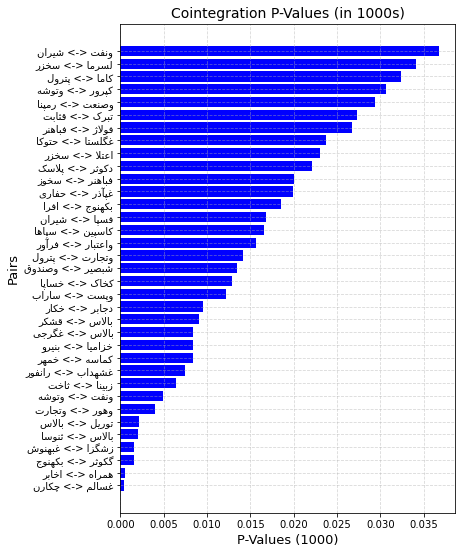

In [22]:
plt.figure(figsize=(6, 9))
plt.barh(sorted_pairs_labels, pairs_p_values, color='blue')
plt.xlabel('P-Values (1000)', fontsize=13)
plt.ylabel('Pairs', fontsize=13)
plt.title('Cointegration P-Values (in 1000s)', fontsize=14)
plt.grid(axis='both', linestyle='--', alpha=0.5)
plt.show()

<p dir=rtl style="direction: ltr;text-align: center;line-height:200%;font-family:vazir;font-size:medium;align:left">
    <font face="B nazanin" size=4.5>
<br>
<b>
    Considering the p-value values, two shares along with news related to the same industry are selected to design a pairs trading system.
</b>
<br>
</p>

#### 4. EDA on 2 selected symbols

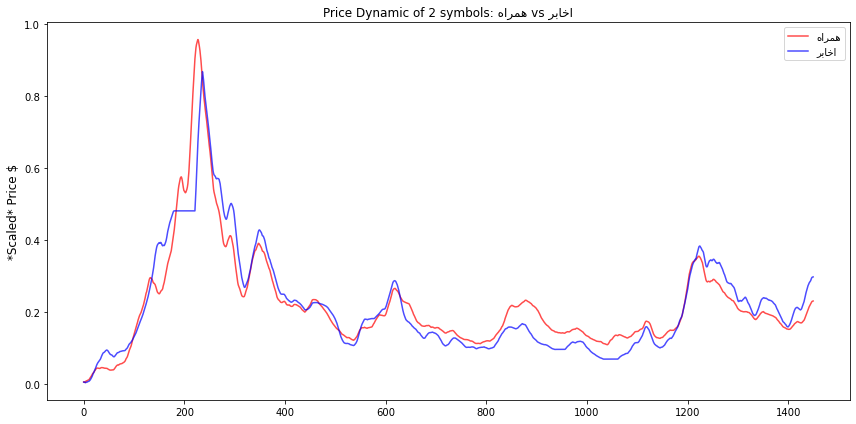

In [23]:
ticker1 = "همراه"
ticker2 = "اخابر"
fig_ticker1 = get_display(arabic_reshaper.reshape(ticker1))
fig_ticker2 = get_display(arabic_reshaper.reshape(ticker2))


scaler = MinMaxScaler()
scaled_data1 = scaler.fit_transform(sanitized_data[ticker1]['close'].values.reshape(-1, 1))
scaled_data2 = scaler.fit_transform(sanitized_data[ticker2]['close'].values.reshape(-1, 1))
scaled_data1_smooth = pd.Series(scaled_data1.flatten()).rolling(window=15, min_periods=1).mean()
scaled_data2_smooth = pd.Series(scaled_data2.flatten()).rolling(window=15, min_periods=1).mean()

plt.figure(figsize=(12, 6))
plt.plot(scaled_data1_smooth, label=f'{fig_ticker1}', color='red', alpha=0.7)
plt.plot(scaled_data2_smooth, label=f'{fig_ticker2}', color='blue', alpha=0.7)
plt.ylabel('*Scaled* Price $', fontsize=12)
plt.title(f'Price Dynamic of 2 symbols: {fig_ticker1} vs {fig_ticker2}')
plt.legend()
plt.tight_layout()
plt.show()


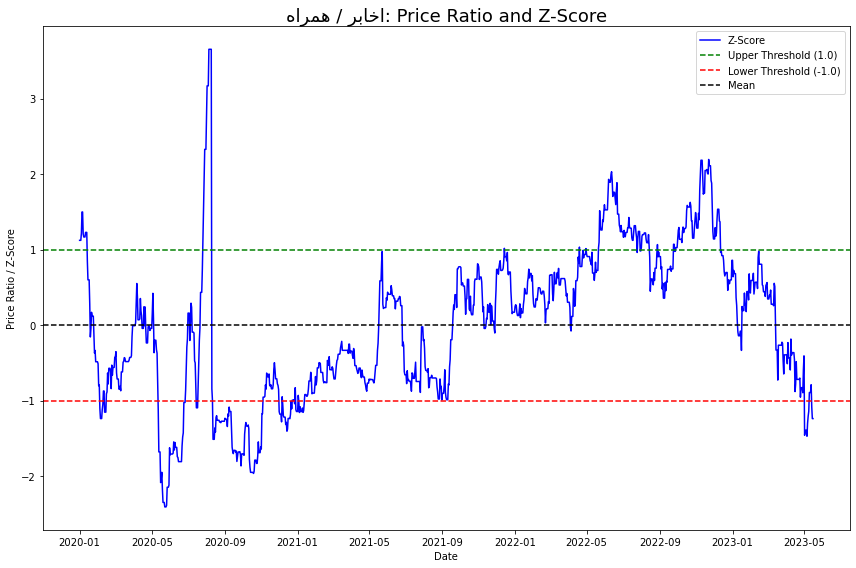

In [24]:
train_length = int(len(sanitized_data[ticker1]) * 0.85)
TEST = len(sanitized_data[ticker2]) - train_length
ticker1_ts = sanitized_data[ticker1]["close"][:train_length]
ticker2_ts = sanitized_data[ticker2]["close"][:train_length]

# Calculate price ratio (ticker1 / ticker2)
ratios = ticker1_ts/ticker2_ts
fig, ax = plt.subplots(figsize=(12, 8))
ratios_mean = np.mean(ratios)
ratios_std = np.std(ratios)
ratios_zscore = (ratios - ratios_mean) / ratios_std
ax.plot(ratios.index, ratios_zscore, label="Z-Score", color='blue')

# Plot reference lines
ax.axhline(1.0, color="green", linestyle='--', label="Upper Threshold (1.0)")
ax.axhline(-1.0, color="red", linestyle='--', label="Lower Threshold (-1.0)")
ax.axhline(0, color="black", linestyle='--', label="Mean")
ax.set_title(f'{fig_ticker1} / {fig_ticker2}: Price Ratio and Z-Score', fontsize=18)
ax.set_xlabel('Date')
ax.set_ylabel('Price Ratio / Z-Score')
ax.legend()
plt.tight_layout()
plt.show()

#### 5. Designing a trading system

In [25]:
def plot_strategy(prices_df, signal_df, profit):
    """
    Plot a trading strategy with buy and sell signals and cumulative profit.
    Parameters:
    - prices (pandas.Series): A Series containing stock prices.
    - signals (pandas.DataFrame): A DataFrame with buy (1) and sell (-1) signals.
    - profit (pandas.Series): A Series containing cumulative profit over time.
    Returns:
    - ax1 (matplotlib.axes.Axes): The top subplot displaying stock prices and signals.
    - ax2 (matplotlib.axes.Axes): The bottom subplot displaying cumulative profit.
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': (3, 1)},
                                   figsize=(18, 12))
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price in $')
    ax1.plot(prices_df.index, prices_df, color='g', lw=0.25)
    # Plot the Buy and Sell signals
    ax1.plot(signal_df.loc[signal_df.orders == 1.0].index,
             prices_df[signal_df.orders == 1.0],
             '^', markersize=12, color='blue', label='Buy')
    ax1.plot(signal_df.loc[signal_df.orders == -1.0].index,
             prices_df[signal_df.orders == -1.0],
             'v', markersize=12, color='red', label='Sell')
    ax2.plot(profit.index, profit, color='b')
    ax2.set_ylabel('Cumulative Profit (%)')
    ax2.set_xlabel('Date')
    return ax1, ax2

In [26]:
def calculate_profit(signals, prices):
    """
    Calculate cumulative profit based on trading signals and stock prices.
    Parameters:
    - signals (pandas.DataFrame): A DataFrame containing trading signals (1 for buy, -1 for sell).
    - prices (pandas.Series): A Series containing stock prices corresponding to the signal dates.
    Returns:
    - cum_profit (pandas.Series): A Series containing cumulative profit over time.
    """
    profit = pd.DataFrame(index=prices.index)
    profit['profit'] = 0.0
    buys = signals[signals['orders'] == 1].index
    sells = signals[signals['orders'] == -1].index
    while sells[0] < buys[0]:
        # These are long only strategies, we cannot start with sell
        sells = sells[1:]
    if len(buys) == 0 or len(sells) == 0:
        # no actions taken
        return profit
    if len(sells) < len(buys):
        # Assume we sell at the end
        sells = sells.append(pd.Index(prices.tail(1).index))
    buy_prices = prices.loc[buys]
    sell_prices = prices.loc[sells]
    profit.loc[sells, 'profit'] = sell_prices.values - buy_prices.values
    profit['profit'] = profit['profit'].fillna(0)
    # Make profit cumulative
    profit['cum_profit'] = profit['profit'].cumsum()
    return profit['cum_profit']

<Figure size 1872x1296 with 0 Axes>

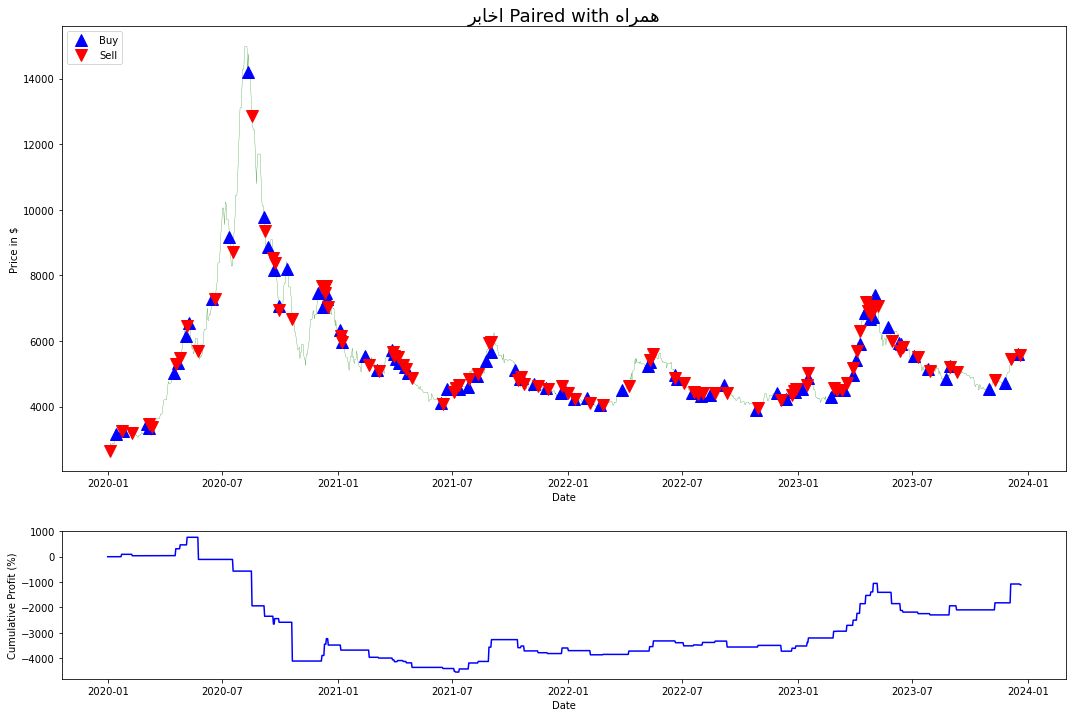

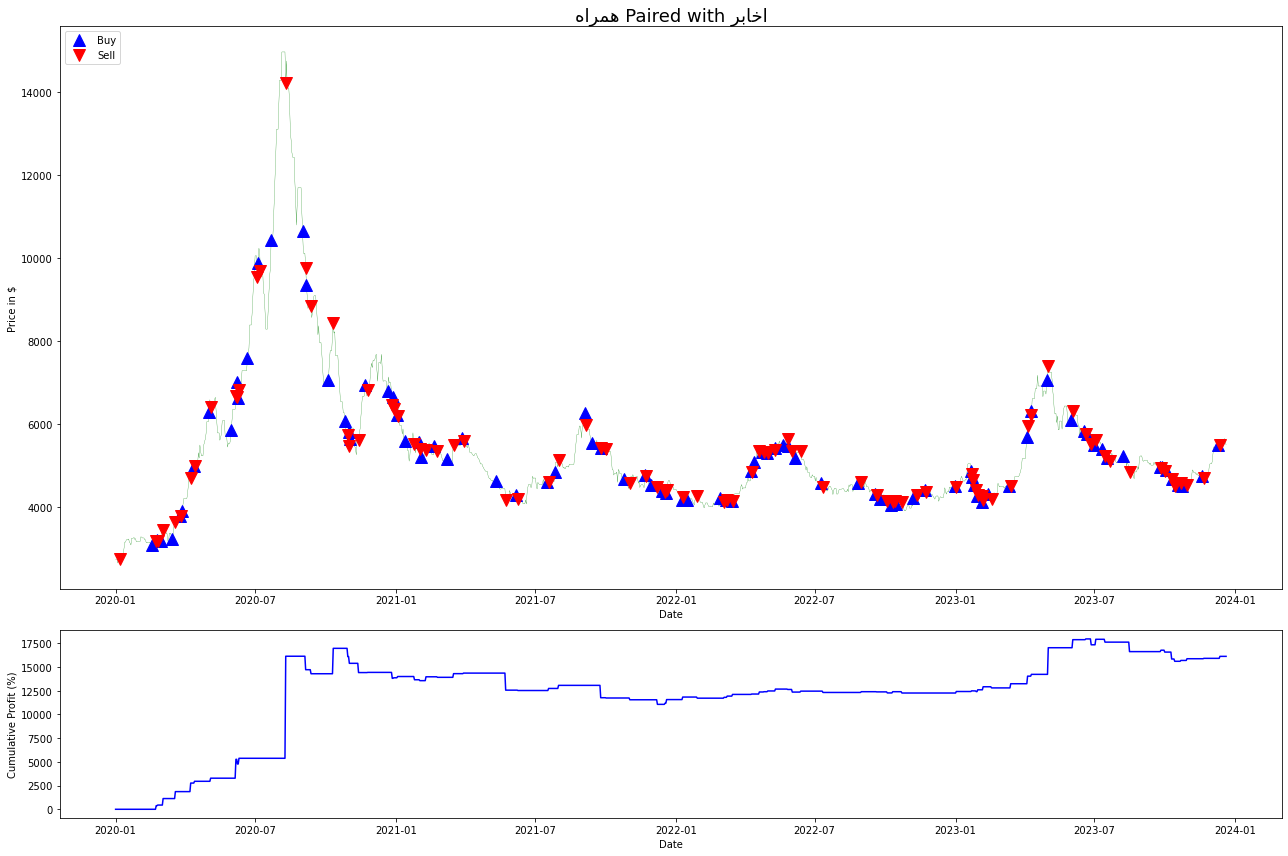

In [30]:
def signals_zscore_evolution(ticker1_ts, ticker2_ts, window_size=15, first_ticker=True):
    """
    Generate trading signals based on z-score analysis of the ratio between two time series.
    Parameters:
    - ticker1_ts (pandas.Series): Time series data for the first security.
    - ticker2_ts (pandas.Series): Time series data for the second security.
    - window_size (int): The window size for calculating z-scores and ratios' statistics.
    - first_ticker (bool): Set to True to use the first ticker as the primary signal source, and False to use the second.Returns:
    - signals_df (pandas.DataFrame): A DataFrame with 'signal' and 'orders' columns containing buy (1) and sell (-1) signals.
    """
    ratios = ticker1_ts / ticker2_ts
    ratios_mean = ratios.rolling(
        window=window_size, min_periods=1, center=False).mean()
    ratios_std = ratios.rolling(
        window=window_size, min_periods=1, center=False).std()
    z_scores = (ratios - ratios_mean) / ratios_std
    buy = ratios.copy()
    sell = ratios.copy()
    if first_ticker:
        # These are empty zones, where there should be no signal
        # the rest is signalled by the ratio.
        buy[z_scores > -1] = 0
        sell[z_scores < 1] = 0
    else:
        buy[z_scores < 1] = 0
        sell[z_scores > -1] = 0
    signals_df = pd.DataFrame(index=ticker1_ts.index)
    signals_df['signal'] = np.where(buy > 0, 1, np.where(sell < 0, -1, 0))
    signals_df['orders'] = signals_df['signal'].diff()
    signals_df.loc[signals_df['orders'] == 0, 'orders'] = None
    return signals_df

ticker1_ts = sanitized_data[ticker1]["close"]
ticker2_ts = sanitized_data[ticker2]["close"]
plt.figure(figsize=(26, 18))
signals_df1 = signals_zscore_evolution(ticker1_ts, ticker2_ts)
profit_df1 = calculate_profit(signals_df1, ticker1_ts)
ax1, _ = plot_strategy(ticker1_ts, signals_df1, profit_df1)
signals_df2 = signals_zscore_evolution(ticker1_ts, ticker2_ts, first_ticker=False)
profit_df2 = calculate_profit(signals_df2, ticker2_ts)
ax2, _ = plot_strategy(ticker1_ts, signals_df2, profit_df2)
ax1.legend(loc='upper left', fontsize=10)
ax1.set_title(f'{fig_ticker2} Paired with {fig_ticker1}', fontsize=18)
ax2.legend(loc='upper left', fontsize=10)
ax2.set_title(f'{fig_ticker1} Paired with {fig_ticker2}', fontsize=18)
plt.tight_layout()
plt.show()

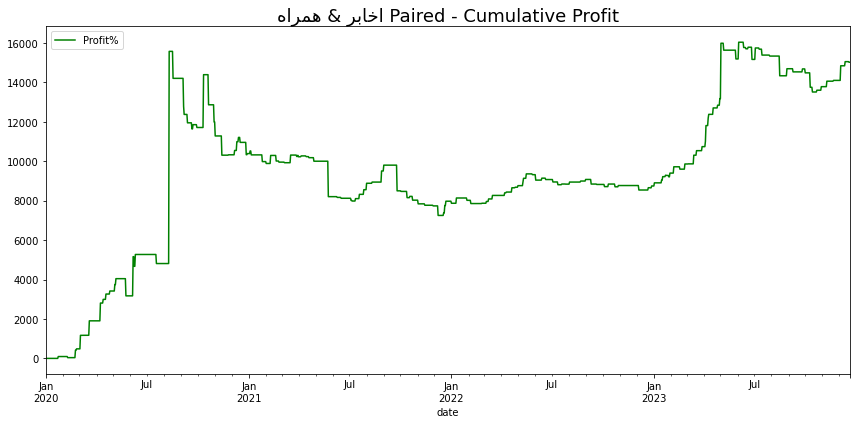

In [31]:
plt.figure(figsize=(12, 6))
cumulative_profit_combined = profit_df1 + profit_df2
ax2_combined = cumulative_profit_combined.plot(
    label='Profit%', color='green')
plt.legend(loc='upper left', fontsize=10)
plt.title(f'{fig_ticker1} & {fig_ticker2} Paired - Cumulative Profit', fontsize=18)
plt.tight_layout()
plt.show()